In [1]:
import torch
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from dataset import TargetDataset, preprocess_data
from model import TransformerPredictor

In [2]:
# PARAMETERS
SIZE = 64
OBSERVATION_WINDOW = 17

data_runs = pd.read_csv('../data/dataset_s64_h0.csv')
data_scenarios = pd.read_csv('../data/scenarios_s64_h0.csv')
data = pd.merge(data_runs, data_scenarios[["layout", "scenario", "goals", "target_goal"]], on=["layout", "scenario"])
data = preprocess_data(data, OBSERVATION_WINDOW, SIZE)

In [3]:
nlayouts = len(data["layout"].unique())
data.loc[data["layout"]<=nlayouts*0.7, "PARTITION"] = "TRAIN"
data.loc[(data["layout"]>nlayouts*0.7) & (data["layout"]<=nlayouts*0.85), "PARTITION"] = "VALID"
data.loc[data["layout"]>nlayouts*0.85, "PARTITION"] = "TEST"

In [4]:
# Dynamically determine input dimension
state_dim = 6
action_dim = len(data.iloc[0]['action_encoding'])
goals_dim = len(data.iloc[0]['goals_encoding'])
grid_dim = data["grid_encoding"][0].shape[0]
mlp_grid_dim = [grid_dim, 256, 64, 30]

goals_dim = len(data.iloc[0]['goals_encoding'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerPredictor(state_dim=state_dim, goals_dim=goals_dim, mlp_grid_dim=mlp_grid_dim, window=OBSERVATION_WINDOW,
                             num_layers=1, num_heads=4, output_dim=action_dim).to(device)
model.load_state_dict(torch.load("models/basicDiscrete-2025-02-24_11:57:50.379798.pth", weights_only=True))
model.eval()

dataset = TargetDataset(data, OBSERVATION_WINDOW)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

/home/crarojasca/Storage/anaconda3/envs/ansr/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
predictions = []
for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    pred = model(batch)#.tolist()
    pred = torch.nn.functional.softmax(pred, dim=1).detach().cpu().tolist()
    predictions += pred 

dataset.index["probs"] = predictions
data_pred = pd.merge(data.reset_index(drop=False), dataset.index, on=["index"])
data_pred["pred"] = data_pred["probs"].apply(lambda x: np.argmax(x))

  0%|          | 0/418 [00:00<?, ?it/s]

In [6]:
# Compute the classification metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
# Evaluate the model
for p in ["TRAIN", "VALID", "TEST"]:
    data_pred_p = data_pred[data_pred["PARTITION"] == p]
    y_pred = data_pred_p["pred"].values
    y_true = data_pred_p["action"].astype(int).values

    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Precision {p}: {precision}")
    print(f"Recall {p}: {recall}")
    print(f"F1 {p}: {f1}")
    print(f"Accuracy {p}: {accuracy}")

# y_true = data_pred[""]["action"].values


Precision TRAIN: 0.7467508046958992
Recall TRAIN: 0.6603444139925454
F1 TRAIN: 0.6942668164491681
Accuracy TRAIN: 0.8184583114840063
Precision VALID: 0.6111507792962175
Recall VALID: 0.5407805525563844
F1 VALID: 0.5663024803503119
Accuracy VALID: 0.7406890130353817
Precision TEST: 0.6212089800601193
Recall TEST: 0.5387693403014976
F1 TEST: 0.5667017305611547
Accuracy TEST: 0.7449344457687723


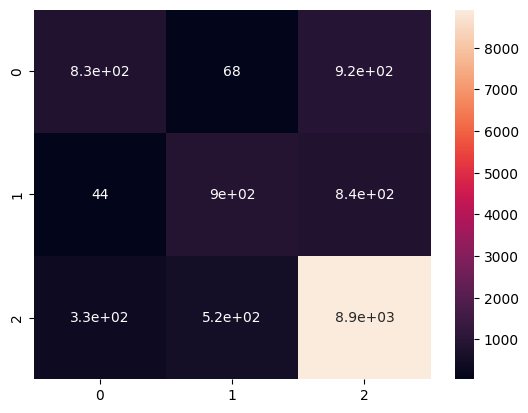

In [10]:
# Confussion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(data_pred["action"].astype(int), data_pred["pred"].astype(int))#,# normalize="false")
sns.heatmap(cm, annot=True)
plt.show()

In [12]:
data_pred["action"].value_counts(normalize=True)

action
2.0    0.730784
0.0    0.136143
1.0    0.133074
Name: proportion, dtype: float64

In [ ]:
def process_pred(pred):
    coord = tuple(np.round(np.array(pred[:2])*SIZE).astype(int))
    orientation = int(np.argmax(pred[2:6]))
    instance_end = int(np.round(pred[6]))

    return pd.Series({
        "pred_target_pos": coord, 
        "pred_orientation": orientation, 
        "pred_instance_end": instance_end})

data_pred[["pred_target_pos", "pred_orientation", "pred_instance_end"]] = data_pred["pred"].apply(process_pred)

data_pred["next_target_pos"] = data_pred["target_pos"].tolist()[1:] + [(0, 0)]
data_pred["next_target_pos"] = data_pred.apply(lambda x: (0, 0) if x["instance_end"] == 1 else x["next_target_pos"], axis=1)
data_pred["next_target_dir"] = data_pred["target_dir"].tolist()[1:] + [0]
data_pred["next_target_dir"] = data_pred.apply(lambda x: 0 if x["instance_end"] == 1 else x["next_target_dir"], axis=1)

In [30]:
data_pred.loc[data_pred["PARTITION"]=="VALID", ["target_pos", "target_dir",  
                                                "next_target_pos", "next_target_dir", "instance_end",
                                                "pred_target_pos", "pred_orientation", "pred_instance_end"]]#.to_csv("predictions.csv", index=False)

,target_pos,target_dir,next_target_pos,next_target_dir,instance_end,pred_target_pos,pred_orientation,pred_instance_end
6280,"(7, 6)",2,"(6, 6)",2,0,"(7, 8)",2,0
6281,"(6, 6)",2,"(5, 6)",2,0,"(9, 9)",2,0
6282,"(5, 6)",2,"(4, 6)",2,0,"(8, 8)",2,0
6283,"(4, 6)",2,"(3, 6)",2,0,"(7, 8)",2,0
6284,"(3, 6)",2,"(3, 6)",1,0,"(6, 8)",2,0
...,...,...,...,...,...,...,...,...
7675,"(18, 20)",3,"(18, 20)",0,0,"(15, 16)",0,0
7676,"(18, 20)",0,"(19, 20)",0,0,"(16, 17)",0,0
7677,"(19, 20)",0,"(20, 20)",0,0,"(16, 16)",0,0
7678,"(20, 20)",0,"(21, 20)",0,0,"(17, 16)",0,0


In [ ]:
#Metrics

data_pred["distance2goal"] = data_pred.apply(lambda x: np.linalg.norm(np.array(x["pred_target_pos"]) - np.array(x["target_goal"])) \
                                             - np.linalg.norm(np.array(x["target_pos"]) - np.array(x["target_goal"])), axis=1)

TypeError: eval() arg 1 must be a string, bytes or code object

In [36]:
data_pred.loc[data_pred["PARTITION"]=="VALID", ["distance2goal"]].mean()

distance2goal    12.249336
dtype: float64